In [16]:
# Library

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import layers, preprocessing
from keras.layers import Activation, Conv2D, BatchNormalization, ReLU, GlobalAveragePooling2D, Dense, Input
from keras.layers import DepthwiseConv2D, MaxPool2D, Flatten, Dropout, GlobalAvgPool2D, Rescaling
from keras.optimizers import Adam
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, History
from keras.backend import clear_session
from keras.activations import get

from functools import partial

import warnings    # 경고메시지 제외
warnings.filterwarnings(action='ignore')
from silence_tensorflow import silence_tensorflow
silence_tensorflow() 


In [17]:
# BaseDataSet Path
DATA_DIR = '/Users/brian/Desktop/genielabs dev3/basedata'

In [18]:
# Set Batch_Size 
batch_size = 32

# Set Target Size
img_height = 224
img_width = 224

In [19]:
# Reading images from Directory and Pass them to the model!!
train_data = tf.keras.preprocessing.image_dataset_from_directory(
  DATA_DIR,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_data = tf.keras.preprocessing.image_dataset_from_directory(
  DATA_DIR,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10000 files belonging to 50 classes.
Using 8000 files for training.
Found 10000 files belonging to 50 classes.
Using 2000 files for validation.


In [20]:
# Modeling Funtion
def resnet34():
    AUTOTUNE = tf.data.experimental.AUTOTUNE

    train_ds = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_data.cache().prefetch(buffer_size=AUTOTUNE)
    normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

    normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
    image_batch, labels_batch = next(iter(normalized_ds))
    first_image = image_batch[0]
    # Notice the pixels values are now in `[0,1]`.
    # print(np.min(first_image), np.max(first_image))

    DefaultConv2D = partial(Conv2D, kernel_size=3, strides=1,
                            padding="SAME", use_bias=False)

    class ResidualUnit(keras.layers.Layer):
        def __init__(self, filters, strides=1, activation="relu", **kwargs):
            super().__init__(**kwargs)
            self.activation = get(activation)
            self.main_layers = [
                DefaultConv2D(filters, strides=strides),
                BatchNormalization(),
                self.activation,
                DefaultConv2D(filters),
                BatchNormalization()]
            self.skip_layers = []
            if strides > 1:
                self.skip_layers = [
                    DefaultConv2D(filters, kernel_size=1, strides=strides),
                    BatchNormalization()]

        def call(self, inputs):
            Z = inputs
            for layer in self.main_layers:
                Z = layer(Z)
            skip_Z = inputs
            for layer in self.skip_layers:
                skip_Z = layer(skip_Z)
            return self.activation(Z + skip_Z)
        
    data_augmentation = Sequential([
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal",
                                                            input_shape=(img_height,
                                                                        img_width,
                                                                        3)),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
    ])
    clear_session()

    model = Sequential()
    model.add(data_augmentation)
    model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                            input_shape=[img_height, img_width, 3]))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPool2D(pool_size=3, strides=2, padding="SAME"))
    prev_filters = 64
    for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
        strides = 1 if filters == prev_filters else 2
        model.add(ResidualUnit(filters, strides=strides))
        prev_filters = filters
    model.add(GlobalAvgPool2D())
    model.add(Flatten())
    model.add(Dense(50, activation="softmax"))


    model.compile(optimizer = 'adam', 
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                metrics = ['accuracy'])
    
    return model

In [21]:
model = resnet34()

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 112, 112, 64)      9408      
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 64)       0         
 )                                                               
                                                                 
 residual_unit (ResidualUnit  (None, 56, 56, 64)       7

In [23]:
# EarlyStopping Params
es = EarlyStopping(monitor='val_accuracy',     # 관측 대상
                min_delta=0,                # 0이면 최소한 성능이 나빠지지 않으면 괜찮아!
                patience=7,                 # 성능이 개선되지 않는다면 몇번이나 참을래
                verbose=1,                  # 몇 epochs가 최선인지 보여줌
                restore_best_weights=True)  # 최선의 epochs의 가중치로 돌려줌!

In [24]:
# Model Fitting Funtion
def fit_and_evaluate(train_data, val_data, epochs_value):
    model = None
    model = resnet34()
    result = model.fit(x = train_data, validation_data = val_data, epochs = epochs_value, callbacks=[es])
    
    return result

In [25]:
epochs_value = 50   # Set Epochs Value
n_folds = 5         # Model Loop Value

# Save the Model History in a List for Plot Later
model_history = [] 

for i in range(n_folds):
    print('Training on Fold : ', i+1)
    model_history.append(fit_and_evaluate(train_data, val_data, epochs_value))
    print("======="*12, end="\n\n\n")

Training on Fold :  1
Epoch 1/50
250/250 [==============================] - 82s 312ms/step - loss: 3.1029 - accuracy: 0.1886 - val_loss: 14.3452 - val_accuracy: 0.0370
Epoch 2/50
250/250 [==============================] - 75s 298ms/step - loss: 2.5810 - accuracy: 0.2763 - val_loss: 7.2090 - val_accuracy: 0.0700
Epoch 3/50
250/250 [==============================] - 72s 288ms/step - loss: 2.3024 - accuracy: 0.3459 - val_loss: 4.3447 - val_accuracy: 0.2265
Epoch 4/50
250/250 [==============================] - 73s 290ms/step - loss: 2.1303 - accuracy: 0.3849 - val_loss: 3.0325 - val_accuracy: 0.3250
Epoch 5/50
250/250 [==============================] - 72s 287ms/step - loss: 1.9495 - accuracy: 0.4285 - val_loss: 5.5042 - val_accuracy: 0.1690
Epoch 6/50
250/250 [==============================] - 72s 289ms/step - loss: 1.8427 - accuracy: 0.4500 - val_loss: 2.5049 - val_accuracy: 0.3850
Epoch 7/50
250/250 [==============================] - 72s 289ms/step - loss: 1.7129 - accuracy: 0.4927 - va

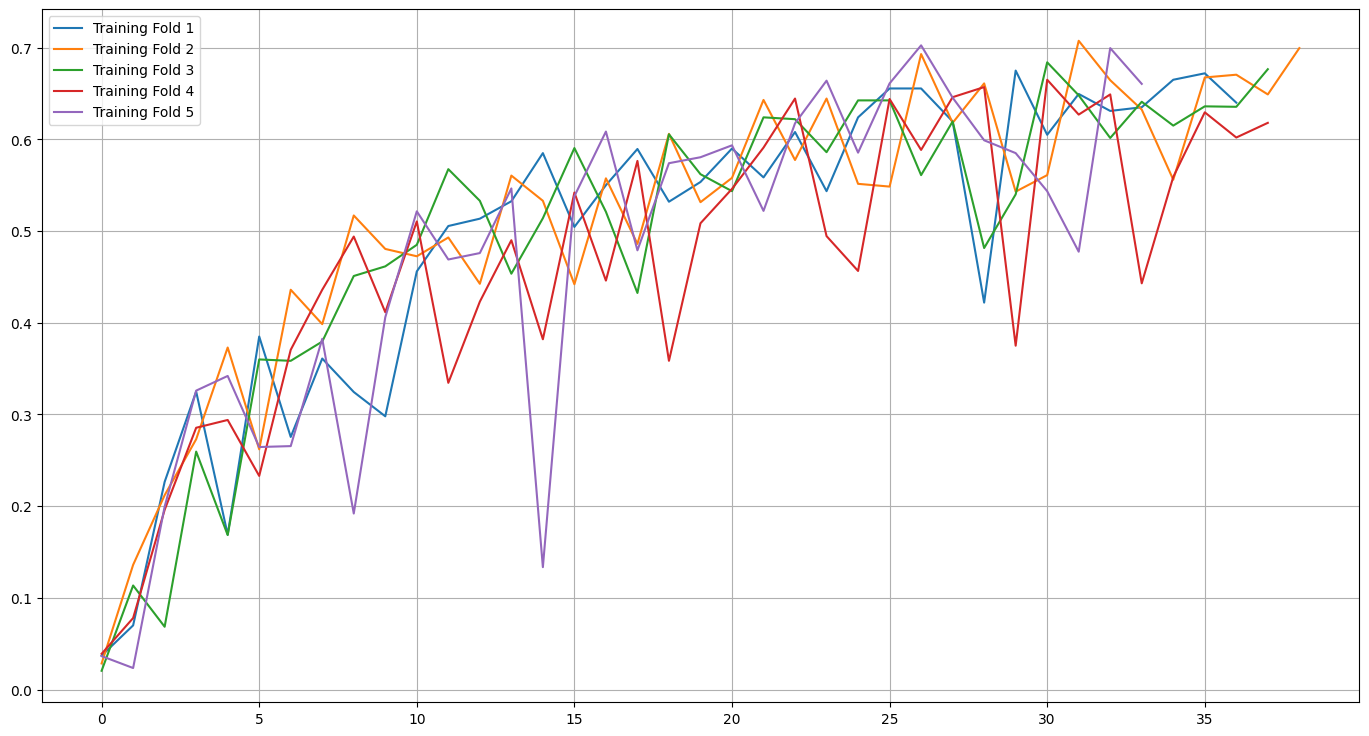

In [46]:
plt.figure(figsize=(17,9))
plt.plot(model_history[0].history['val_accuracy'], label='Training Fold 1')
plt.plot(model_history[1].history['val_accuracy'], label='Training Fold 2')
plt.plot(model_history[2].history['val_accuracy'], label='Training Fold 3')
plt.plot(model_history[3].history['val_accuracy'], label='Training Fold 4')
plt.plot(model_history[4].history['val_accuracy'], label='Training Fold 5')
plt.legend()
plt.grid()
plt.show()

In [77]:
df = pd.DataFrame({'var_acc' : 'best',
                   'Fold 1' : pd.DataFrame(model_history[0].history['val_accuracy']).max(),
                   'Fold 2' : pd.DataFrame(model_history[1].history['val_accuracy']).max(),
                   'Fold 3' : pd.DataFrame(model_history[2].history['val_accuracy']).max(),
                   'Fold 4' : pd.DataFrame(model_history[3].history['val_accuracy']).max(),
                   'Fold 5' : pd.DataFrame(model_history[4].history['val_accuracy']).max()})
df.set_index('var_acc', inplace=True)
df

,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5
var_acc,,,,,
best,0.675,0.7075,0.684,0.665,0.7025


In [80]:
mean = df.loc['best'].mean()
print(f"Best 5 Cross Validation Accuracy : {mean: .4f}")


Best 5 Cross Validation Accuracy :  0.6868
